In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))

from src.lmpc.objectives import QuadForm
from src.lmpc.controller_models import LMPC
from src.lmpc.locality_models import dLocality
from src.lmpc.system_models import DistributedLTI
from src.lmpc.constraints import TerminalConstraint
from src.lmpc.utils import generateRandomSquareMeshLTI, plot_topology_locality

In [2]:
# system params
n = 3       # grid size
Ns = 2      # states per subsystem
Na = 1      # acitons per subsystem
LOCALITY = 1
T = 10      # mpc horizon
Tsim = 40   # scenario sim time

# dynamics matrix of random mesh system
A, B = generateRandomSquareMeshLTI(n, seed=2024)
# cost matrices
Q = np.eye(n*n*Ns)
R = np.eye(n*n*Na)

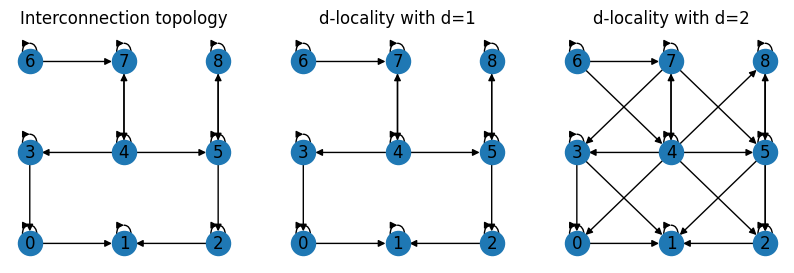

In [3]:
# init system
sys = DistributedLTI(n*n, Ns, Na)
sys.loadAB(A, B)
sys << dLocality(d=LOCALITY)
plot_topology_locality(sys, n, LOCALITY)

In [4]:
# init controller
controller = LMPC(T)
controller << sys

# add objective
controller.addObjectiveFun(QuadForm(Q, R))
# add terminal constraint (= 0 by default)
controller.addConstraint(TerminalConstraint())

In [5]:
# scenario
# init condition
x0 = 0.5 * np.ones((sys.Nx, 1))
sys.setInitialState(x0)

# history buffer
cost_history = np.zeros((Tsim))
x_history = np.zeros((Tsim+1, 1, sys.Nx))
x_history[0] = x0.T

# run scenrario
for t in range(Tsim):
  u, cost = controller.solve(sys._x)
  x = sys.step(u)
  sys.updateState(x) 
  cost_history[t] = cost
  x_history[t+1, 0, :] = x.squeeze()

Initial cost = 53.22240635549883


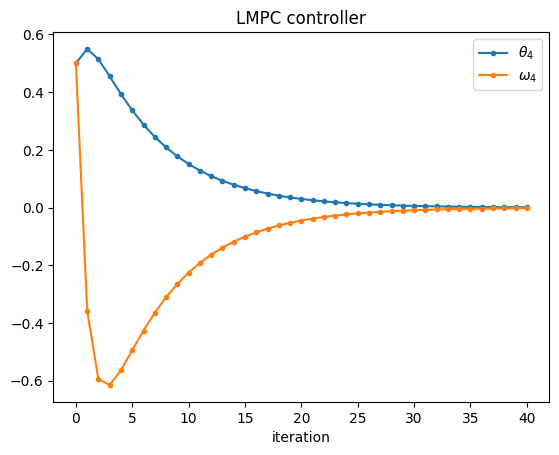

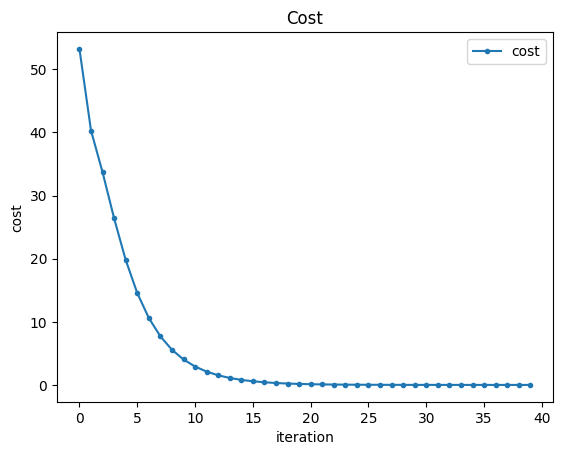

In [6]:
plt.plot(np.arange(0, Tsim+1), x_history[:, 0, 6], ".-", label="$\\theta_4$")
plt.plot(np.arange(0, Tsim+1), x_history[:, 0, 7], ".-", label="$\omega_4$")
plt.xlabel("iteration")
plt.ylabel("")
plt.title("LMPC controller")
plt.legend(loc="best")


plt.figure()
plt.plot(np.arange(0, Tsim), cost_history, ".-", label="cost")
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("Cost")
plt.legend(loc="best")

print(f"Initial cost = {cost_history[0]}")